In [14]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

In [15]:
# M -> K <- N
# M -> N

SAMP_SIZE = 10000

M = stats.norm.rvs(size=SAMP_SIZE)
N = stats.norm.rvs(M)
K = stats.norm.rvs(N-M)

# creating a pandas dataframe
d = {'M': M,
    'N': N,
    'K': K}
df = pd.DataFrame(data=d)
df.head()

,M,N,K
0,0.978308,1.236188,0.016414
1,-0.630519,1.468113,2.046201
2,0.775733,0.367834,0.449304
3,1.671592,1.483790,0.843022
4,1.789098,1.124883,-3.325828


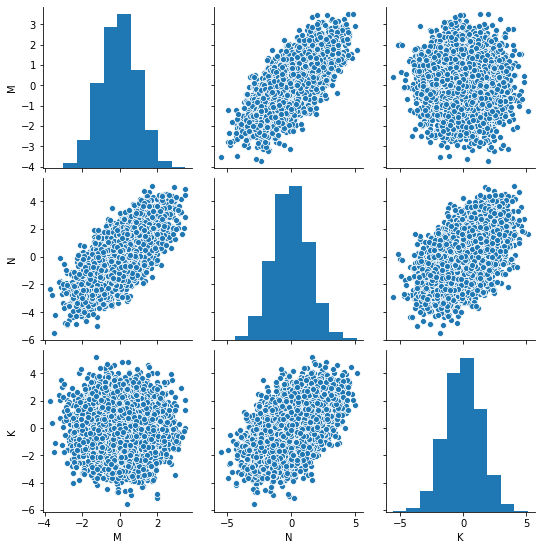

In [16]:
sns.pairplot(data=df)

### Regression M->K

In [17]:
with pm.Model() as mask:
    a = pm.Normal('a', 0, 0.2)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bM*M)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['K'])
    
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 2770.75draws/s]


In [18]:
varnames = ['~mu']
az.summary(trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.01,0.01,-0.03,0.02
bM,-0.01,0.01,-0.03,0.02
sigma,1.41,0.01,1.39,1.43


### Regression N->K

In [19]:
with pm.Model() as mask:
    a = pm.Normal('a', 0, 0.2)
    bN = pm.Normal('bN', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bN*N)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['K'])
    
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 3060.14draws/s]


In [20]:
varnames = ['~mu']
az.summary(trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.01,0.01,-0.02,0.03
bN,0.49,0.01,0.48,0.51
sigma,1.22,0.01,1.20,1.24


### Multivariate regression M->K<-N

In [21]:
with pm.Model() as mask:
    a = pm.Normal('a', 0, 0.2)
    bN = pm.Normal('bN', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bN*N + bM*M)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['K'])
    
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:05<00:00, 1976.09draws/s]


In [22]:
varnames = ['~mu']
az.summary(trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.01,0.01,-0.03,0.01
bN,0.99,0.01,0.97,1.01
bM,-1.00,0.01,-1.03,-0.98
sigma,1.00,0.01,0.98,1.01
